In [1]:
import numpy as np
import matplotlib.pyplot as plt

def BCS(L, N, m, h, k_B, T, g_eff, n_0, delta_initial, mu_initial, epsilon_D, epsilon_n, alpha_mu, beta_delta,maxloop=2000):

    # Initialize variables
    delta_1 = delta_initial
    mu = mu_initial
    
    # Define the energy function
    def calculate_energy(eta_k, delta):
        return np.sqrt(eta_k**2 + delta**2)

    # Define the Fermi-Dirac distribution function
    def fermi_dirac(energy):
        if(energy / (k_B * T) > 100.):
            return 0.0
        elif (energy / (k_B * T) < -100.):
            return 1.0
        else:
            return 1 / (1 + np.exp(energy / (k_B * T)))

    # Define the u_k and v_k functions
    def calculate_u_k(eta_k, energy_k):
        if energy_k >= 0:
            return np.sqrt(0.5 * (1 + eta_k / energy_k))
        else:
            return np.sqrt(1 - 0.5 * (1 + eta_k / energy_k))

    def calculate_v_k(eta_k, energy_k):
        if energy_k >= 0:
            return np.sqrt(1 - 0.5 * (1 + eta_k / energy_k))
        else:
            return -np.sqrt(0.5 * (1 + eta_k / energy_k))

    # Loop until convergence
    for iloop in range(maxloop): 
        # Initialize variables for the loop
        sum_vk_squared_fermi = 0
        sum_uk_vk_ek_fermi = 0

        # Loop over all k values     
        for i in np.arange(-N/2, N/2+1):
            k_x = i * 2 * np.pi / L
            for j in np.arange(-N/2, N/2+1):
                k_y = j * 2 * np.pi / L
                for k in np.arange(-N/2, N/2+1):
                    k_z = k * 2 * np.pi / L
                    
                    # Calculate eta_k and energy_k
                    eta_k = h**2 / (2 * m) * (k_x**2 + k_y**2 + k_z**2) - mu
                    energy_k = calculate_energy(eta_k, delta_1)
                    
                    # Loop over negative and positive E 
                    for E in [energy_k,-energy_k]:
                        
                        # Calculate vk and uk
                        uk = calculate_u_k(eta_k, E)
                        vk = calculate_v_k(eta_k, E)
                        
                        # Calculate the sums
                        sum_vk_squared_fermi += vk**2 * fermi_dirac(-E)
                        sum_uk_vk_ek_fermi += uk * vk * (1 - 2 * fermi_dirac(E))

        # Calculate the density
        number_of_particles = 2 * sum_vk_squared_fermi
        density = number_of_particles / L**3

        # Calculate the new delta
        delta_2 = (g_eff**2 / L**3) * sum_uk_vk_ek_fermi
        
        # Update mu and delta_1
        mu += alpha_mu * (n_0 - density)
        delta_1 = beta_delta * delta_2 + (1 - beta_delta) * delta_1
       
        # print(iloop,delta_1,mu,density) #for debugging reasons
        # Check for convergence
        if abs(delta_1 - delta_2) < epsilon_D and abs(n_0 - density) < epsilon_n:
            break
            
        if abs(delta_1) < 1.0e-6: # delta vanished - special calse
            if(alpha_mu>0.0):
                print("WARNING: Delta vanished, switching to fixed chemial potential!")
            alpha_mu=0.0 # later continue for fixed chemical potential
            n_0 = density
            
    if(iloop>=maxloop-1):
        print("WARNING: Algorithm did not converged")    
    
    return delta_1, mu, density, iloop

In [2]:
# Inputs
L = 20
DX=1.0
N = int(L / DX) # number of lattice point in each direction 
m = 1
h = 1
k_B = 1
g_eff = 1.5
kF = 1.0 # desired Fermi wave-vector
eF=h**2*kF**2/(2.*m) # Fermi energy 
T_0 = 0.001
n_0 = kF**3 / (3.*np.pi**2) # set Fermi wave to one, because kF = (3*pi^2 * n) (1/3)
delta_initial = 0.5 * eF # be of the same order as the Fermi energy
mu_initial = eF # be of the same order as the Fermi energy
epsilon = 1e-6
epsilon_n=1e-6
alpha_mu = 0.3
beta_delta = 0.5
#print(N,n_0,kF, eF)

In [3]:
# Calculate µ and ∆ for T = 0
delta_0, mu_0, n, iloop = BCS(L, N, m, h, k_B, T_0, g_eff, n_0, delta_initial, mu_initial, epsilon, epsilon_n, alpha_mu, beta_delta)
kF = (3.*np.pi**2*n)**(1./3.) # Fermi wave-vector for the solution
eF=h**2*kF**2/(2.*m) # Fermi energy 

# Display the results
#print(iloop)
#print("n=%.4f eF=%.4f T/eF=%.4f µ/eF=%.4f ∆/eF=%.4f" % (n,eF,T_0/eF,mu/eF,delta/eF))
print("µ(T/eF = 0)/eF =", round(mu_0/eF,4))
print("∆(T/eF = 0)/eF =", round(delta_0/eF,4))

µ(T/eF = 0)/eF = 0.8195
∆(T/eF = 0)/eF = 0.492


In [4]:
# Define arrays for various temperatures
arr_mu = [mu_0]
arr_delta = [delta_0]
arr_T = [T_0]
critical_temperature = 0

# Iterate over temperatures
for T in np.linspace(0.01, 0.45*eF, 30):
    # Calculate µ and ∆
    delta, mu, n, iloop = BCS(L, N, m, h, k_B, T, g_eff, n_0, delta_initial, mu_initial, epsilon, epsilon_n, alpha_mu, beta_delta)
       
    arr_mu.append(mu)
    arr_delta.append(delta)
    arr_T.append(T)
    
    # if delta vanished set T_c
    if (abs(delta) < 1.0e-4) and (critical_temperature == 0):
        critical_temperature = T
        
print("Critical Temperature (T_c):", round(critical_temperature,2),"K")
print("Check if ∆(T = 0) ≈ 1.76kBTc")
print("∆(T = 0) =", delta_0)
print("1.76kBTc =", 1.76*k_B*critical_temperature)

Critical Temperature (T_c): 0.18 K
Check if ∆(T = 0) ≈ 1.76kBTc
∆(T = 0) = 0.24602487686365543
1.76kBTc = 0.3177163106156046


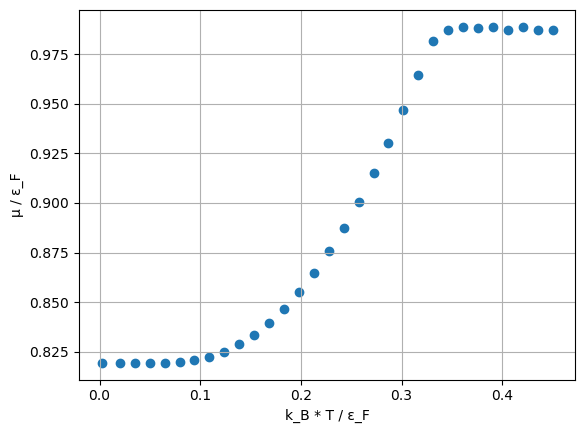

In [5]:
# Plot the chemical potential dependence of temperature
plt.scatter(np.asarray(arr_T) * k_B / eF, np.asarray(arr_mu) / eF, label='µ(T)')
plt.xlabel('k_B * T / ε_F')
plt.ylabel('µ / ε_F')
plt.grid(True)
plt.savefig('mu.pdf')
plt.show()

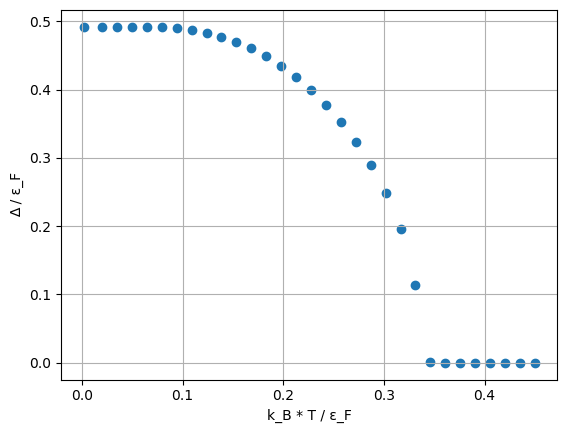

In [6]:
# Plot the energy gap dependence of temperature
plt.scatter(np.asarray(arr_T) * k_B / eF, np.asarray(arr_delta) / eF, label='∆(T)')
plt.xlabel('k_B * T / ε_F')
plt.ylabel('∆ / ε_F')
plt.grid(True)
plt.savefig('delta.pdf')
plt.show()

In [7]:
delta_iloop = []
for i in np.linspace(0.1, 1, 10):
    delta, mu, n, iloop = BCS(L, N, m, h, k_B, T_0, g_eff, n_0, delta_initial, mu_initial, epsilon, epsilon_n, alpha_mu, i)
    delta_iloop.append(iloop)

In [8]:
mu_iloop = []
for i in np.linspace(0.1, 1, 10):
    delta, mu, n, iloop = BCS(L, N, m, h, k_B, T_0, g_eff, n_0, delta_initial, mu_initial, epsilon, epsilon_n, i, beta_delta)
    mu_iloop.append(iloop)

In [9]:
eD_iloop = []
en_iloop = []
for i in [1e-1,1e-2,1e-3,1e-4,1e-5,1e-6]:
    delta, mu, n, iloop = BCS(L, N, m, h, k_B, 0.18, g_eff, n_0, delta_initial, mu_initial, i, epsilon_n, alpha_mu, beta_delta)
    eD_iloop.append(iloop)
    delta, mu, n, iloop = BCS(L, N, m, h, k_B, 0.18, g_eff, n_0, delta_initial, mu_initial, epsilon, i, alpha_mu, beta_delta)
    en_iloop.append(iloop)

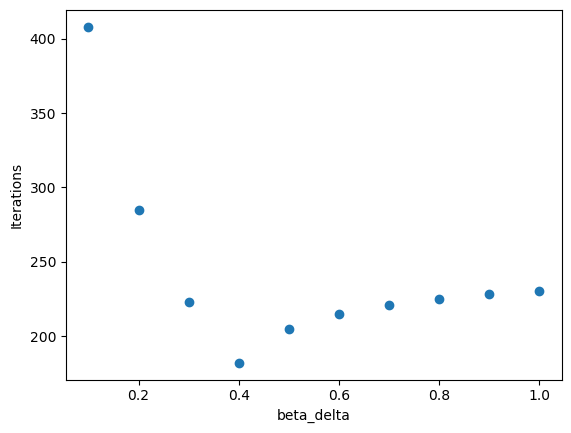

In [10]:
plt.scatter(np.linspace(0.1, 1, 10), delta_iloop)
plt.xlabel("beta_delta")
plt.ylabel("Iterations")
plt.savefig('beta_delta.pdf')
plt.show()

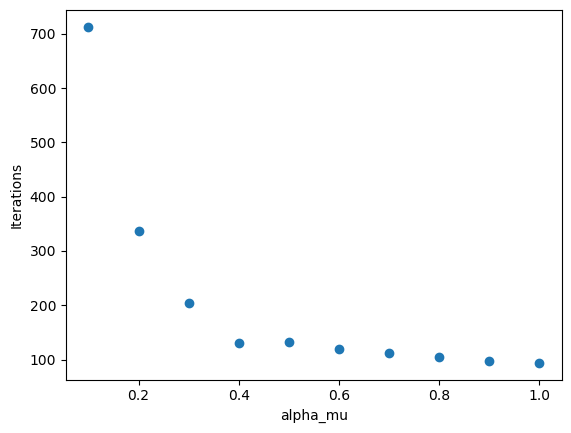

In [11]:
plt.scatter(np.linspace(0.1, 1, 10), mu_iloop)
plt.xlabel("alpha_mu")
plt.ylabel("Iterations")
plt.savefig('alpha_mu.pdf')
plt.show()

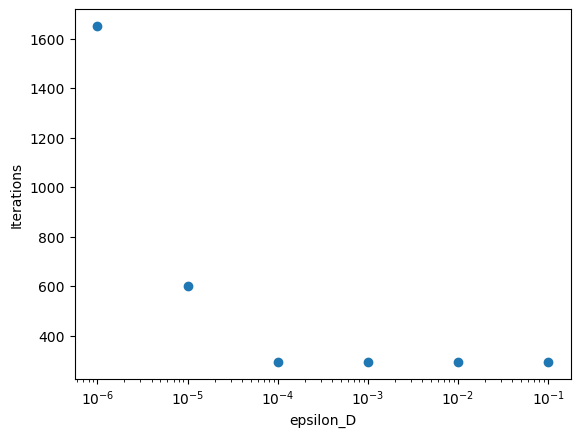

In [12]:
plt.scatter([1e-1,1e-2,1e-3,1e-4,1e-5,1e-6], eD_iloop)
plt.xlabel("epsilon_D")
plt.ylabel("Iterations")
plt.xscale('log')
plt.savefig('epsilon_D.pdf')
plt.show()

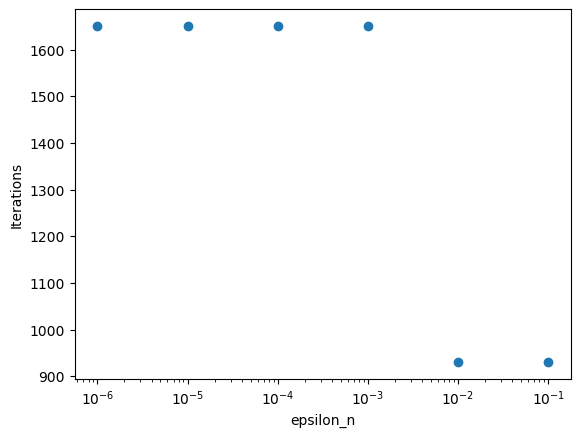

In [13]:
plt.scatter([1e-1,1e-2,1e-3,1e-4,1e-5,1e-6], en_iloop)
plt.xlabel("epsilon_n")
plt.ylabel("Iterations")
plt.xscale('log')
plt.savefig('epsilon_n.pdf')
plt.show()

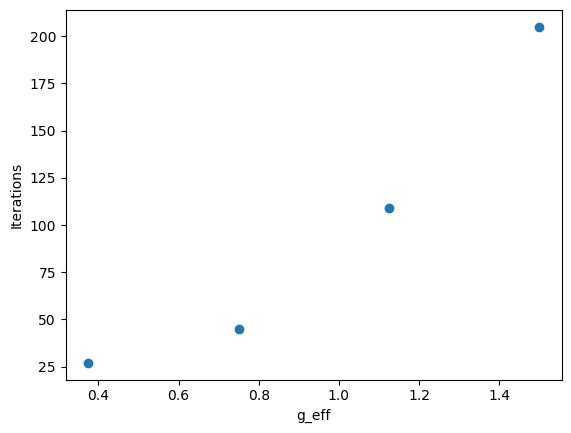

In [14]:
g_iloop = []
for i in [g_eff,0.75*g_eff, 0.5*g_eff, 0.25*g_eff]:
    delta, mu, n, iloop = BCS(L, N, m, h, k_B, T_0, i, n_0, delta_initial, mu_initial, epsilon, epsilon_n, alpha_mu, beta_delta)
    g_iloop.append(iloop)
    
plt.scatter([g_eff,0.75*g_eff, 0.5*g_eff, 0.25*g_eff], g_iloop)
plt.xlabel("g_eff")
plt.ylabel("Iterations")
plt.savefig('g_eff.pdf')
plt.show()